#  1/13 spiral undersampling reconstruction using SENSE conjugate gradient

### Using TensorflowMRI and Python 3.12

In [1]:
import json
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from time import time
from joblib import Parallel, delayed
import warnings

sys.path.append(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir))
sys.path.append(os.path.join(os.getcwd(), os.pardir, os.pardir))

from Tools.load_save_utils import load_acquisition_reconstruction_from_nii, load_model_weights
from Tools.reconstruction_utils import NN_prediction

from Plot.plot_utils import plot_parameter_maps
from Neural_Networks.networks import initialize_network
from CG_SENSE.cg_sense_new_version import reconstruct_lstsq
import function_reconstruction_spirale

warnings.filterwarnings("ignore")

2025-06-25 20:27:43.790217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-25 20:27:43.811463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-25 20:27:43.817939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 20:27:43.836892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-25 20:27:44.630133: W tensorflow/compiler/tf2

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


/home/cungel/data_ssd/venv/venv_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

In [2]:
#Path to summer and to data
path_to_summer_current = "/data_network/summer_projects/cungel/Current"

#Load brain ROI
roi_brain_filepath = "2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240424/ROI_data/MAPIRMAGE-D00-ROI-brain2D_20240426-085037219"
path_to_ROI_brain_map = os.path.join(path_to_summer_current, roi_brain_filepath)
ROI_brain, _, _ =  load_acquisition_reconstruction_from_nii(path_to_ROI_brain_map, nb_indents=1, v=False)

#Load k-space from FS cartesian data
Philips_raw_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/20240424_FS_ksp_full.npy")
k_space = np.load(Philips_raw_filepath)

#Load coil sensitivity
sens = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/20240424_sens.npy")
sensitivity_map = np.load(sens)

#Load Philips reconstruction
Philips_reco_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/reco_FS.npy")
RECO = np.load(Philips_reco_filepath)

#Load Philips spiral trajectory
traj_spirale_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/20240410_traj_spirale_philips.npy")
traj_spirale = np.load(traj_spirale_filepath)
traj_spirale = traj_spirale[0:2,:]*np.pi / np.max(traj_spirale[0:2,:])


## Obtain image from the FS k-space and crop data to obtain 192x192 images

In [3]:
image = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(k_space, axes = (3,4)), axes = (3,4)), axes = (3,4))

#Crop the first and the last quarters of the image
start_index = int(k_space.shape[4] / 4)
end_index = int(k_space.shape[4] * 3 / 4)

image = image[:,:,:,:, start_index:end_index:1]

In [4]:
sensitivity_map_crop = sensitivity_map[:,:,start_index:end_index]

sensitivity_map_crop = tf.convert_to_tensor(sensitivity_map_crop)

2025-06-25 20:29:38.098665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44136 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:25:00.0, compute capability: 7.5


## Define a spiral with variable density

You can either load a trajectory in .npy with the previous script and go directly to "Generate many spirales", in this case you can pass directly your trajectory to result_nufft function, or you can use the SigPy method to generate a trajectory  

### Sigpy trajectory

In [5]:
spiral_traj = function_reconstruction_spirale.spiral_sigpy(fov=0.192, 
              N=192, 
              f_sampling=1, 
              R=12, 
              ninterleaves=1, 
              alpha=4, 
              gm=0.004, 
              sm=200)

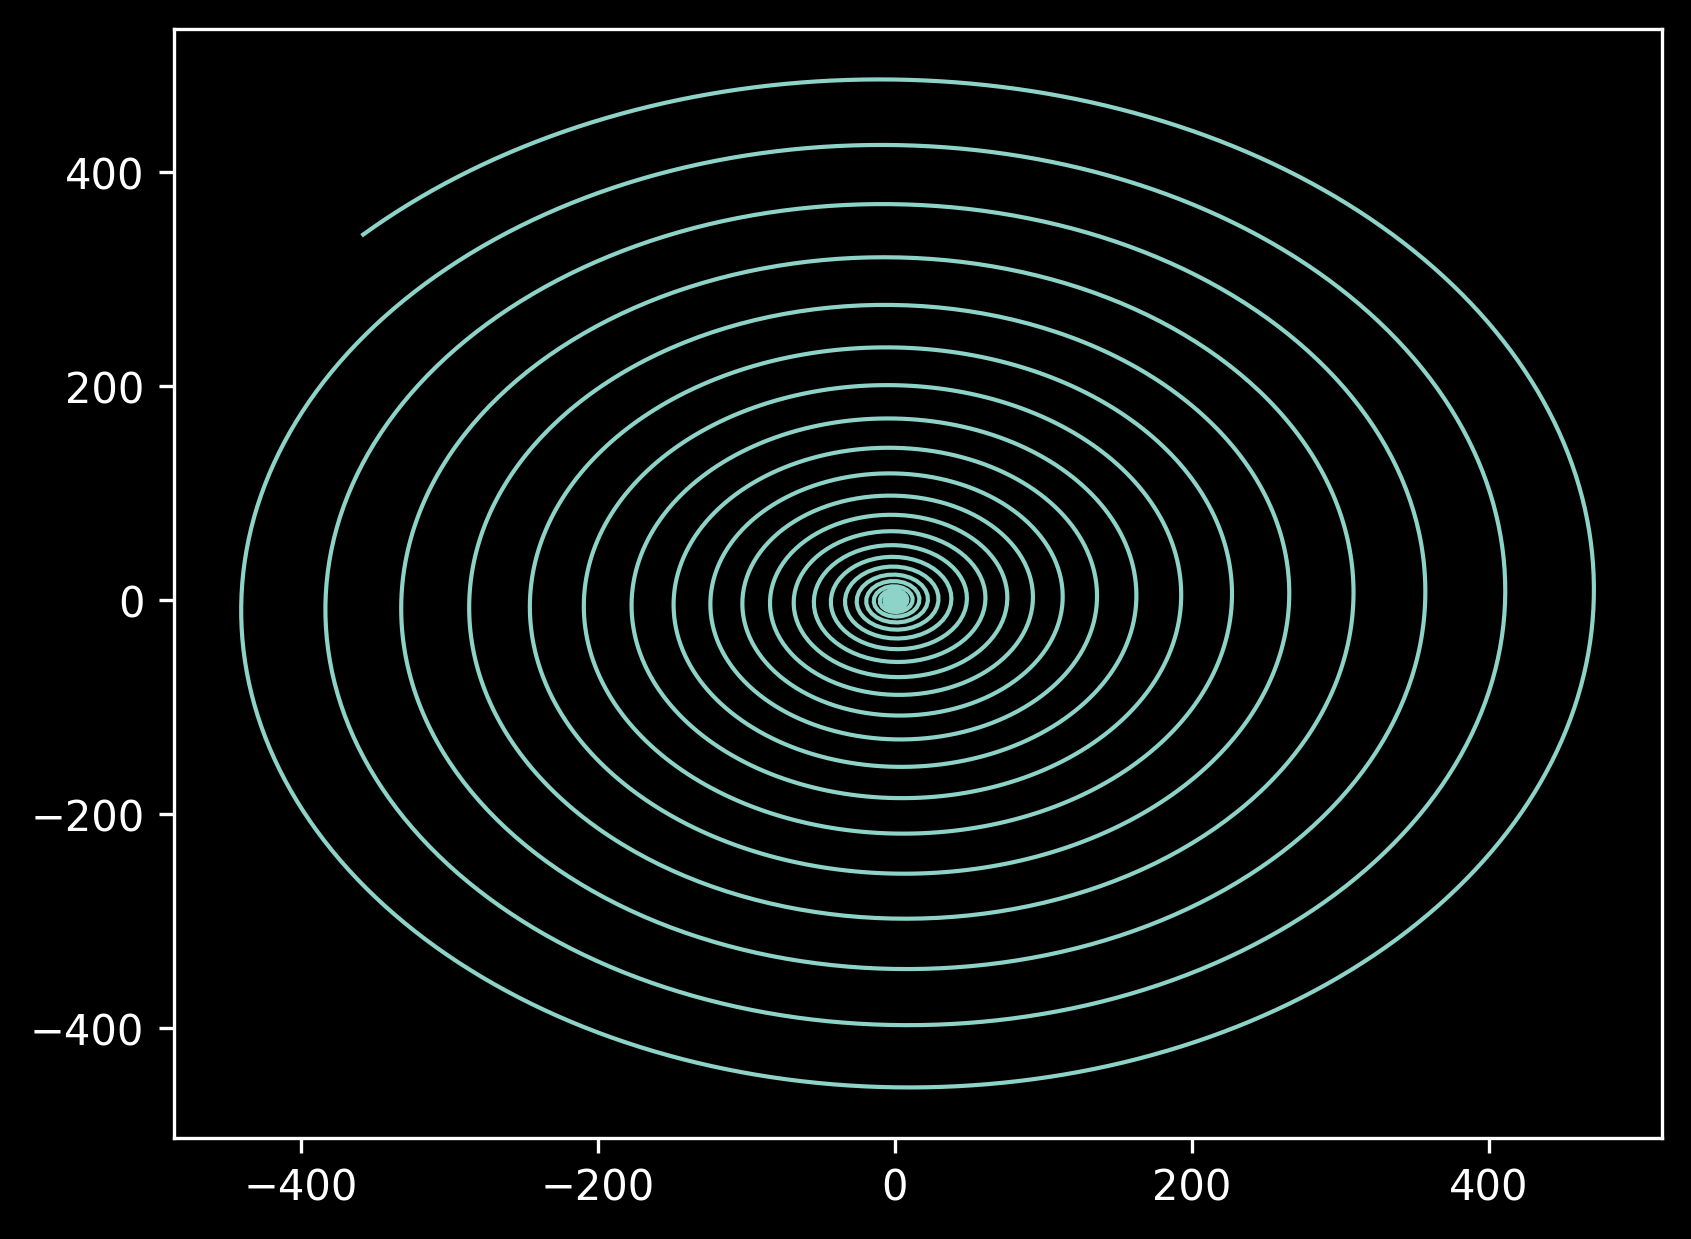

In [6]:
plt.plot(spiral_traj[:,0], spiral_traj[:,1], linewidth=1)

In [7]:
spiral_traj = spiral_traj*np.pi / np.max(spiral_traj)
spiral_traj = spiral_traj.T

## Use NUFFT to obtain undersampled k-space associated with a spiral trajectory

In [ ]:
def result_nufft(image, n_spirale, traj_spirale_norma):
    '''
    Parallelization of NUFFT functions on all pulses.
    '''
    k_space_nufft_sum =  np.zeros((260, 31, n_spirale * traj_spirale_norma.shape[1]), complex) 
    tot_trajectory = []

    #The function is parallelized on each pulse
    results = Parallel(n_jobs=-1)(delayed(function_reconstruction_spirale.process_nufft)(pulse, traj_spirale_norma, n_spirale, image, 
                                                                                         spiral_rotation = True, Nd=(192,192), Kd=(192*2,192*2), Jd=(6,6)) 
                                                                                         for pulse in range(260))  
    
    #The results are stored in k_space_nufft_sum for all pulses and the associated trajectories are stored in tot_trajectory.
    for pulse, k_space_nufft, conc_trajectory in results:
        k_space_nufft_sum[pulse, :, :] = k_space_nufft
        tot_trajectory.append(conc_trajectory)
    
    return k_space_nufft_sum, tot_trajectory

"""First case: use .npy file to define a trajectory
trajectory = traj_spirale"""

"""Second case: use the function to generate a spiral trajectory"""
trajectory = function_reconstruction_spirale.spiral_sigpy(fov=0.192, 
              N=192, 
              f_sampling=1, 
              R=12, 
              ninterleaves=1, 
              alpha=4, 
              gm=0.004, 
              sm=200).T

trajectory_norma = trajectory*np.pi / np.max(trajectory)
k_space_nufft_sum, tot_trajectory = result_nufft(image, 1, trajectory_norma)

2025-06-25 20:29:49.182519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-25 20:29:49.204869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-25 20:29:49.213908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 20:29:49.228688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-25 20:29:49.241150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

### Checks

In [9]:
tot_trajectory_arr = np.asarray(tot_trajectory)

In [10]:
k_space_nufft_sum.shape

(260, 31, 3675)

In [11]:
tot_trajectory[0].shape

(3675, 2)

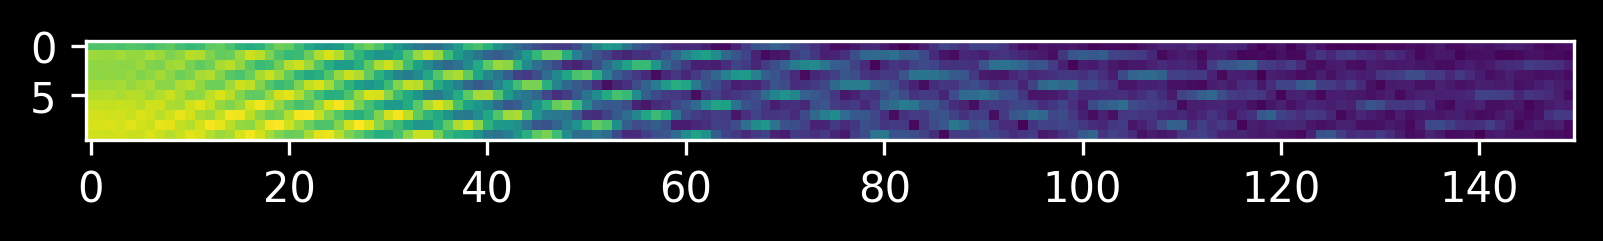

In [12]:
plt.imshow(np.abs(k_space_nufft_sum[0:10,0,0:150]))

## Use CG-SENSE to reconstruct the image from the undersampled k-space, trajectory and sensitivity maps

In [13]:
#CG-SENSE is based on tensorflow: convert numpy array to tensor 
tot_trajectory_array = np.array(tot_trajectory)

traj_tf = tf.convert_to_tensor(tot_trajectory_array)
traj_tf = tf.cast(traj_tf, tf.float32)

k_space_tf = tf.convert_to_tensor(k_space_nufft_sum, dtype = tf.complex64)

In [16]:
cg_sense_classic= reconstruct_lstsq(k_space_tf, image_shape=[192,192],extra_shape=260,dynamic_domain='time', trajectory =traj_tf, sensitivities=sensitivity_map_crop, optimizer='cg', optimizer_kwargs={'max_iterations': 60})

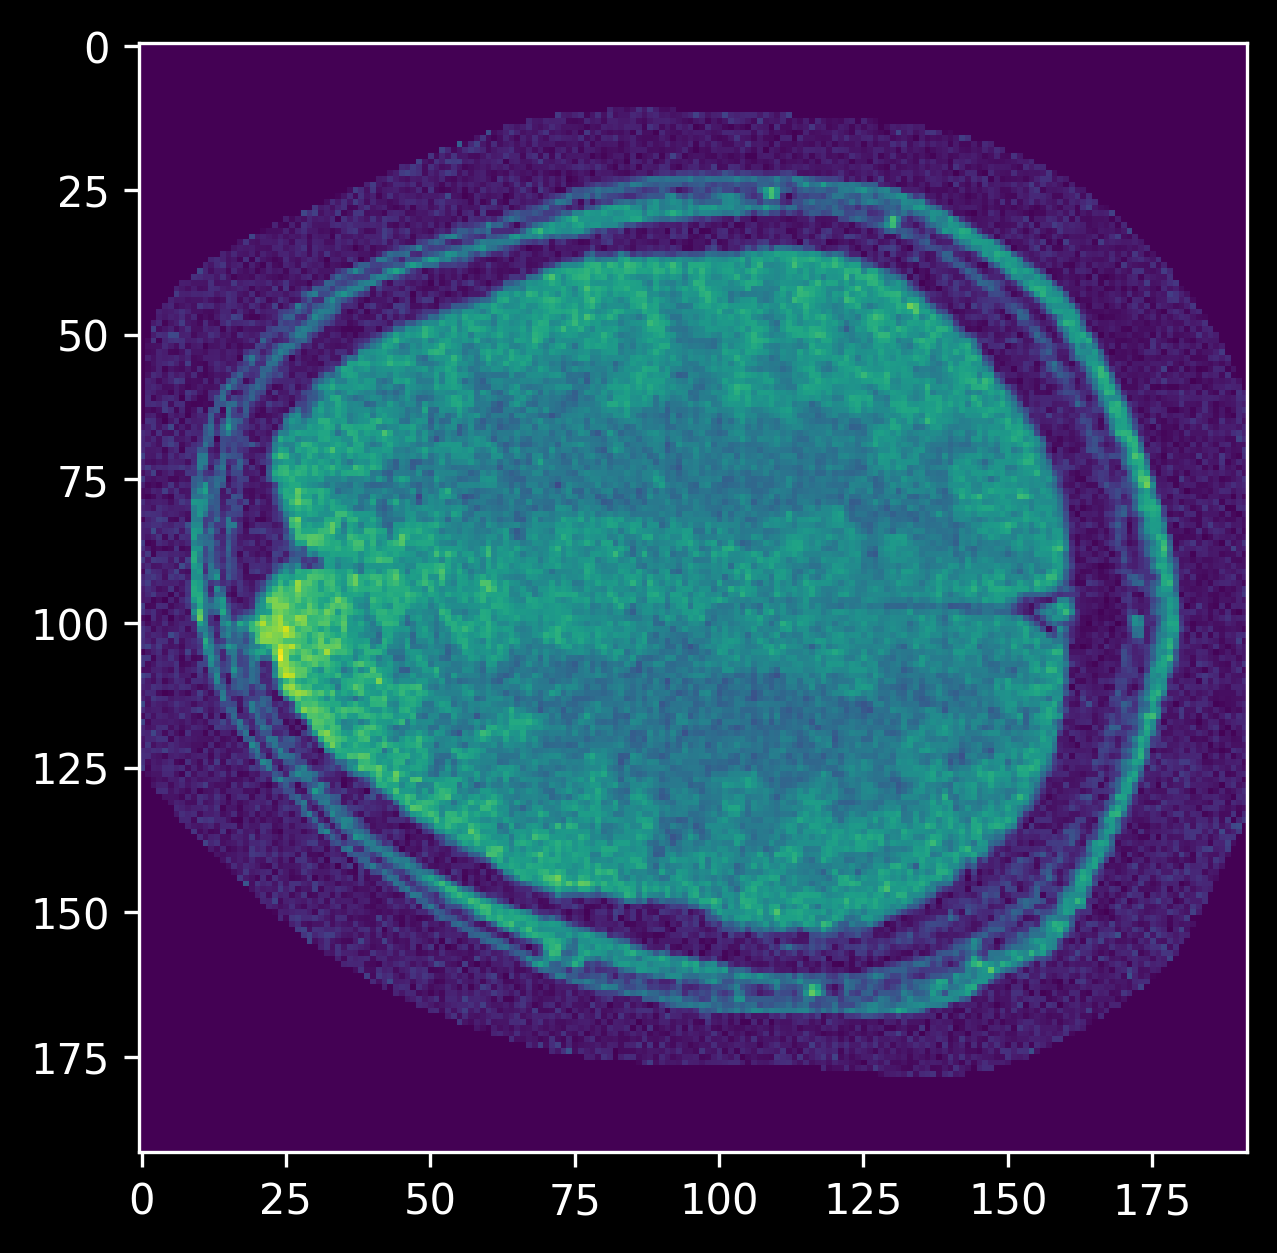

In [15]:
plt.imshow(np.abs(cg_sense_classic[0,:,:]))

## MARVEL reconstructions

In [13]:
training_path = os.path.join(path_to_summer_current, '2023_MRF_Collab/Lila/MARVEL_training/DICO8/train_updated_code_v2_LR0.9')

RECOS_INFOS = json.load(open(os.path.join(training_path, 'training_infos.json')))

In [14]:
# Initialize the network
n_pulses = 260
n_epochs = 87

start = time()
print("\nINITIALIZE NETWORK")
NETWORK_INFOS = RECOS_INFOS["NETWORK_INFOS"]
learned_labels = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
n_parameters = len(learned_labels)
layer_B1_constraint_incorporation = NETWORK_INFOS.get("incorporate_B1_constraint", False)

network_name = "BiLSTM"
input_size = n_pulses 
print(input_size)
layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"] + [n_parameters]
activations = NETWORK_INFOS["activations"]

NN = initialize_network(network_name, layer_shapes, activations, layer_B1_constraint_incorporation)

load_model_weights(NN, layer_shapes, adding_text='_{}epochs'.format(n_epochs), path_to_model=os.path.join(training_path, 'weights'))

NN.summary()


INITIALIZE NETWORK
260


/home/cungel/data_ssd/venv/venv_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 260, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75)             │         7,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,481 (126.88 KB)

 Trainable params: 32,481 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
cg_sense_array = cg_sense_classic.numpy()
cg_sense_array =np.transpose(cg_sense_array, (1,2,0))
cg_sense_array = np.expand_dims(cg_sense_array, 2)

ROI_brain_map_rot = np.rot90(ROI_brain==1)
if ROI_brain_map_rot.ndim == 2:
    ROI_brain_map_rot = ROI_brain_map_rot[:, :, None]

label_parameters = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']

#Rotation and normalization

RECO_rot = np.rot90(RECO)
RECO_norm = np.abs(RECO_rot)/np.maximum(np.linalg.norm(np.abs(RECO_rot), axis=3)[:, :, :, None], 1e-10)

CG_reconstruction_rot = np.rot90(cg_sense_array,-1)
CG_reconstruction_norm = np.abs(CG_reconstruction_rot)/np.maximum(np.linalg.norm(np.abs(CG_reconstruction_rot), axis=3)[:, :, :, None], 1e-10)

#Predictions

NN_reconstruction_RECO = NN_prediction(NN, RECO_norm, label_parameters, ROI_brain_map_rot, batch_size=1024)
NN_reconstruction_CG = NN_prediction(NN, CG_reconstruction_norm, label_parameters, ROI_brain_map_rot, batch_size=1024)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


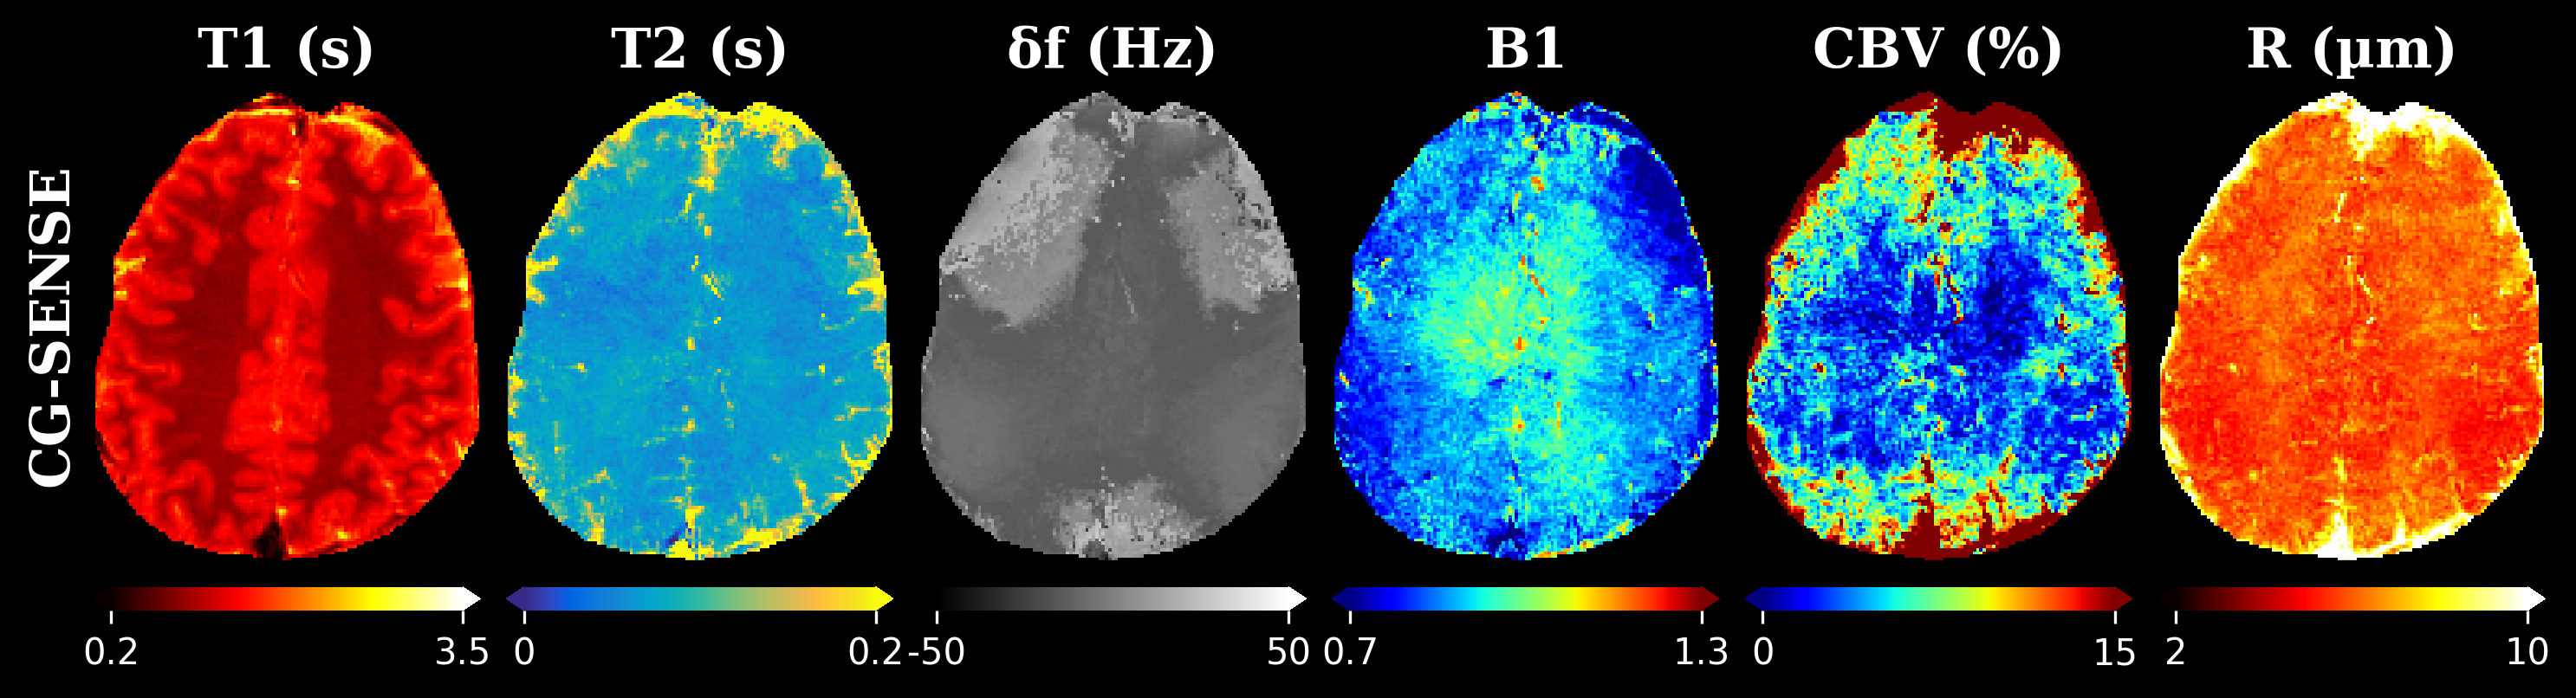

In [74]:
#Plot MARVEL outputs

#fig = plot_parameter_maps(NN_reconstruction_RECO, label_parameters, title='', crop_type='separate', slice_titles = ['RECO'],path_to_data=training_path, file_name='{}_{}epochs'.format("first_test", n_epochs))
fig = plot_parameter_maps(NN_reconstruction_CG, label_parameters, title='', crop_type='separate',slice_titles = ['CG-SENSE'],path_to_data=training_path, file_name='{}_{}epochs'.format("first_test", n_epochs))